This notebook is designed as one's first machine learning experiment. We will load and visualize a dataset of human heights and weights, and use a simple model to predict weight from height.

**After you've read, run, and understood the code, try to modify it as follows:**
* Easy: predict height from weight
* Easy: Add data normalization using a sklearn StandardScaler, as you learned in [the previous tutorial](DataAndTensors.ipynb). This should make optimization much faster because the initial neural network parameters are closer to optimal. **It's a good rule of thumb that a neural network's inputs should have approximately zero mean and unit standard deviation.**
* Harder: Test how using a too complex network for simple data can lead to overfitting and nonsensical predictions. Use data normalization as above and only the 50 first datapoints of the dataset. Use a network with two 32-neuron ReLU layers. You can add the first layer as ```model.add(keras.layers.Dense(32,activation="relu",input_shape=(1,)))``` and the next layers similarly, but without specifying the input_shape, which Keras can figure out by itself.

Model solutions are provided in the same folder, but first try to solve the problem yourself, at least for a few minutes. *Think of this as a puzzle game with optional hints that you will check only if you have to.*

Let's start by including the basic utilities. Now, we also need tensorflow in addition to numpy and pyplot. We also import Keras because it makes building and training basic neural networks easy.

For a bit more complex but similar example, see https://www.tensorflow.org/tutorials/keras/basic_classification

In [1]:
import numpy as np
import matplotlib.pyplot as pp
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #disable Tensorflow GPU usage, a simple example like this runs faster on CPU
import tensorflow as tf
from tensorflow import keras  
from sklearn.preprocessing import StandardScaler

Next we load the data and convert to metric system, similar to the previous tutorial.

Text(0, 0.5, 'Weight (kilograms)')

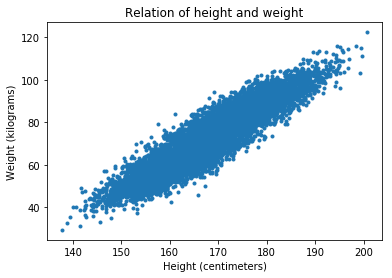

In [2]:
data=np.loadtxt("../Datasets/weight-height.csv",skiprows=1,usecols=(1,2),delimiter=",")
data[:,0]*=2.54
data[:,1]*=0.45359237
pp.scatter(data[:,0],data[:,1],marker=".")
pp.title("Relation of height and weight")
pp.xlabel("Height (centimeters)")
pp.ylabel("Weight (kilograms)")

To predict weight from height, we're going to need a machine learning model. We will first train a single-neuron network, i.e., a simple linear model. 

In [3]:
#keras.Sequential makes it easy to compose a neural network models out of layers
model = keras.Sequential()

#Add a 1-neuron layer with linear activation, taking one input value. 
#The input_shape=(1,) defines that there's only a single input value, but batch size is yet unknown.
#Note that this notation is a bit misleading, as the batch data index dimension is really the first one and not the second one.  
#Fortunately, the input_shape needs to only be specified for the first layer
model.add(keras.layers.Dense(1,input_shape=(1,),use_bias=True))

#Make the model ready for optimization using Adam optimizer (the usual reasonable first guess).
#The loss parameter defines the loss function that optimization tries to minimize, in this case
#the mean squared error between the network outputs and actual data values.
#The lr parameter is the "learning rate". With this simple model, we can use a high learning rate of 0.1,
#whereas many complex networks require 0.001 or even 0.0001. This makes training more stable but also more slow.
model.compile(optimizer=keras.optimizers.Adam(lr=0.1),loss="mean_squared_error")

#Define our training inputs and outputs. Our network takes in height (column 0 in the data) and outputs weight (column 1).
trainingInputs=data[:,0]
trainingOutputs=data[:,1]

#Reshape the tensors: This is needed because Tensorflow and Keras models expect to get data in batches, as specified above.
trainingInputs=np.reshape(trainingInputs,[trainingInputs.shape[0],1])
trainingOutputs=np.reshape(trainingOutputs,[trainingOutputs.shape[0],1])

#Fit the model. Epochs defines how many times the network will see all data during the training.
model.fit(trainingInputs,trainingOutputs,verbose=1,epochs=5)


Epoch 1/5
10000/10000 [==============================] - 1s 58us/step - loss: 3141.5882
Epoch 2/5
10000/10000 [==============================] - 0s 23us/step - loss: 118.0348
Epoch 3/5
10000/10000 [==============================] - 0s 22us/step - loss: 117.5025

Now, let's plot the data again, adding the model predictions.

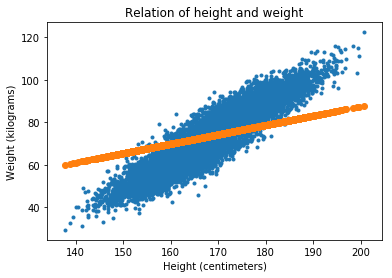

In [4]:
pp.figure(1)
#pp.scatter(data[:,0],data[:,1],marker=".")
pp.scatter(trainingInputs[:,0],trainingOutputs[:,0],marker=".")
pp.title("Relation of height and weight")
pp.xlabel("Height (centimeters)")
pp.ylabel("Weight (kilograms)")
predictions=model.predict(trainingInputs)
#NOTE: The predictions is of the same shape as trainingOutputs, i.e., [10000,1]
#scatter() expects 1-dimensional x and y arrays; thus, we need to use the [:,0] and [:,1] indexing.
pp.scatter(trainingInputs[:,0],predictions[:,0])

What you should see above is a line that predicts growing weight with growing height, but it does not yet fit the data really well. However, the fit gets better when the training continues. Below, we optimize for 50 more epochs and then visualize again. 

Epoch 1/50
 - 0s - loss: 116.1579
Epoch 2/50
 - 0s - loss: 115.1303
Epoch 3/50
 - 0s - loss: 115.1751
Epoch 4/50
 - 0s - loss: 113.1941
Epoch 5/50
 - 0s - loss: 109.9967
Epoch 6/50
 - 0s - loss: 108.3727
Epoch 7/50
 - 0s - loss: 106.8890
Epoch 8/50
 - 0s - loss: 103.8538
Epoch 9/50
 - 0s - loss: 105.0448
Epoch 10/50
 - 0s - loss: 99.5918
Epoch 11/50
 - 0s - loss: 97.8635
Epoch 12/50
 - 0s - loss: 96.8963
Epoch 13/50
 - 0s - loss: 92.4651
Epoch 14/50
 - 0s - loss: 89.7188
Epoch 15/50
 - 0s - loss: 84.8930
Epoch 16/50
 - 0s - loss: 84.1434
Epoch 17/50
 - 0s - loss: 82.9965
Epoch 18/50
 - 0s - loss: 76.7520
Epoch 19/50
 - 0s - loss: 75.7143
Epoch 20/50
 - 0s - loss: 72.2331
Epoch 21/50
 - 0s - loss: 70.3519
Epoch 22/50
 - 0s - loss: 68.2559
Epoch 23/50
 - 0s - loss: 64.7568
Epoch 24/50
 - 0s - loss: 67.2195
Epoch 25/50
 - 0s - loss: 62.4785
Epoch 26/50
 - 0s - loss: 59.9977
Epoch 27/50
 - 0s - loss: 58.9645
Epoch 28/50
 - 0s - loss: 58.3668
Epoch 29/50
 - 0s - loss: 55.9734
Epoch 30/50
 -

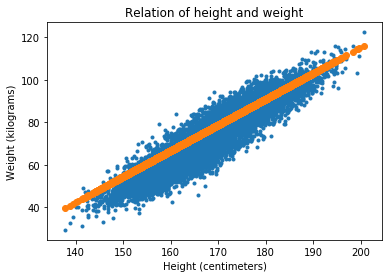

In [5]:
#fit the model
model.fit(trainingInputs,trainingOutputs,verbose=2,epochs=50)  #we predict column 1 from column 0 

#visualize the data
pp.figure(1)
pp.scatter(data[:,0],data[:,1],marker=".")
pp.title("Relation of height and weight")
pp.xlabel("Height (centimeters)")
pp.ylabel("Weight (kilograms)")
predictions=model.predict(trainingInputs)
pp.scatter(trainingInputs[:,0],predictions[:,0])

Now, it's easy to query the model with any height values:

In [6]:
print("The predicted weight for a person who weighs 200kg is ",model.predict([[200]])[0,0])

The predicted weight for a person who weighs 200kg is  115.33539


Note that above, we had to use [[200]], because we only had one value to predict but the network wants a 2D tensor as input. [[200]] defines an array of shape [1,1] with the only element having indices [0,0] and value 200. Similarly, the prediction is a [1,1] shaped tensor, which we query with indices [0,0].

**Unfortunately, this tensor indexing mess is one of the biggest hurdles in getting into ML coding. Don't worry, it's hard for everyone at first. Once you've wrapped your head around it, things will get much easier.**

This simple data can be modeled using a 1-layer network without any nonlinear activation functions. Out of curiosity, let's see what happens when we use a multilayer network with ReLU activations. To see things in more detail, we also only use the first 50 data points.

In [7]:
data=data[:50]
data-=np.mean(data,axis=0)
data/=np.std(data,axis=0)
model = keras.Sequential()
#add a layer with 32 ReLU neurons
model.add(keras.layers.Dense(32,activation="relu",input_shape=(1,)))
#add a layer with 32 ReLU neurons
model.add(keras.layers.Dense(32,activation="relu")
#NOTE: we don't need to specify input_shape for others than the first layer. Keras can deduce it automatically.
#add the output layer (1 neuron because only 1 predicted value)
model.add(keras.layers.Dense(1))
model.compile(optimizer=keras.optimizers.Adam(lr=0.1),loss="mean_squared_error")

#Define our training inputs and outputs. Our network takes in height (column 0 in the data) and outputs weight (column 1).
trainingInputs=data[:,0]
trainingOutputs=data[:,1]

#Reshape the tensors: This is needed because Tensorflow and Keras models expect to get data in batches, as specified above.
trainingInputs=np.reshape(trainingInputs,[trainingInputs.shape[0],1])
trainingOutputs=np.reshape(trainingOutputs,[trainingOutputs.shape[0],1])

#Fit the model. Epochs defines how many times the network will see all data during the training.
model.fit(trainingInputs,trainingOutputs,verbose=2,epochs=100)


Epoch 1/100
 - 0s - loss: 0.7131
Epoch 2/100
 - 0s - loss: 0.4507
Epoch 3/100
 - 0s - loss: 0.6833
Epoch 4/100
 - 0s - loss: 0.3468
Epoch 5/100
 - 0s - loss: 0.4652
Epoch 6/100
 - 0s - loss: 0.3007
Epoch 7/100
 - 0s - loss: 0.3505
Epoch 8/100
 - 0s - loss: 0.3133
Epoch 9/100
 - 0s - loss: 0.2784
Epoch 10/100
 - 0s - loss: 0.2841
Epoch 11/100
 - 0s - loss: 0.2613
Epoch 12/100
 - 0s - loss: 0.2878
Epoch 13/100
 - 0s - loss: 0.2700
Epoch 14/100
 - 0s - loss: 0.2584
Epoch 15/100
 - 0s - loss: 0.2663
Epoch 16/100
 - 0s - loss: 0.2539
Epoch 17/100
 - 0s - loss: 0.2613
Epoch 18/100
 - 0s - loss: 0.2600
Epoch 19/100
 - 0s - loss: 0.2423
Epoch 20/100
 - 0s - loss: 0.2541
Epoch 21/100
 - 0s - loss: 0.2395
Epoch 22/100
 - 0s - loss: 0.2540
Epoch 23/100
 - 0s - loss: 0.2510
Epoch 24/100
 - 0s - loss: 0.2556
Epoch 25/100
 - 0s - loss: 0.2483
Epoch 26/100
 - 0s - loss: 0.2422
Epoch 27/100
 - 0s - loss: 0.2517
Epoch 28/100
 - 0s - loss: 0.2397
Epoch 29/100
 - 0s - loss: 0.2612
Epoch 30/100
 - 0s - lo

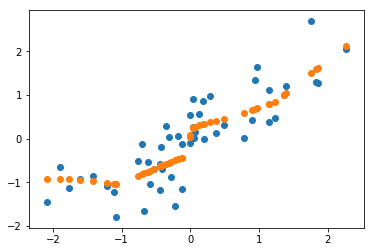

In [8]:
#Scatterplot both the data and the predictions
pp.scatter(trainingInputs,trainingOutputs)
predictions=model.predict(trainingInputs)
pp.scatter(trainingInputs,predictions)